### Create prediction maps for calibrated model

In [1]:
################## 1. Download checkpoints and build models
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var_after_calib
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Union

import torch
import torch.nn.functional as F
from models.var import AdaLNSelfAttn, sample_with_top_k_top_p_, gumbel_softmax_with_rng
from utils.data import pil_loader, normalize_01_into_pm1
from torchvision.transforms import transforms
import cv2
from PIL import Image
MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}
import matplotlib.gridspec as gridspec

In [2]:
def load_prtnd_model(nmb: str, model_depth): 
    # download checkpoint
    #hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
    vae_ckpt, var_ckpt = 'vae_ch160v4096z32_calib_' + nmb +'.pth', f'var_d{model_depth}_calib_' + nmb +'.pth'
    #if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
    #if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

    # build vae, var
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if 'vae' not in globals() or 'var' not in globals():
        vae, var = build_vae_var_after_calib(
            V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
            device=device, patch_nums=patch_nums,
            num_classes=1000, depth=model_depth, shared_aln=False,
        )
    
    vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
    var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
    vae.eval(), var.eval()
    for p in vae.parameters(): p.requires_grad_(False)
    for p in var.parameters(): p.requires_grad_(False)
    print(f'prepare finished.')
    return vae, var

def get_emp_coverage(var):
    scores = var.cal_scores
    for r in range(10): 
        indices = torch.randperm(scores.size(0))
        cutoff = int(0.3*scores.size(0))
        inidces_val = indices[:cutoff]
        inidces_cal = indices[cutoff:]
        scores_calib = scores[inidces_cal, :]
        scores_val =  scores[inidces_val, :]
        
        n = scores_calib.size(0)
        alpha = 0.1
        q_level = np.ceil((n+1)*(1-alpha))/n
        qhats = torch.quantile(scores_calib, q_level, dim=0, interpolation='higher')
        coverage = torch.mean((scores_val <= qhats).bool().float(), dim = 0)
        if r == 0: 
            covs = coverage.unsqueeze(0)
        else: 
            covs = torch.cat((covs, coverage.unsqueeze(0)), dim = 0)
                
    return(torch.mean(covs, dim=0))



def plot_heatmap(tensor, vmax, vmin, linewidth=0.2, title=None, title_y = 0.8):
    num_heatmaps = len(tensor)
    
    if num_heatmaps > 1:
        #fig = plt.figure(figsize=(2 * num_heatmaps + 1, 6))  # Extra space for color bar
        #spec = gridspec.GridSpec(1, num_heatmaps + 1, width_ratios=[0.2] + [1] * num_heatmaps)  # First column for cbar
        fig = plt.figure(figsize=(2 * num_heatmaps + 1, 6))  # Dynamic width
        width_ratios = [0.3] + list(np.linspace(1, num_heatmaps, num_heatmaps))  # First column for cbar

        spec = gridspec.GridSpec(1, num_heatmaps + 1, width_ratios=width_ratios)

        if title:
            fig.suptitle(title, fontsize=14, fontweight='bold', y = title_y)  # Set title

        # First heatmap (with color bar)
        row = tensor[0].squeeze(0)
        size = int(np.sqrt(row.shape))  
        reshaped_row = np.array(row).reshape(size, size)

        ax0 = fig.add_subplot(spec[0, 1])  # First heatmap
        heatmap = sns.heatmap(reshaped_row, annot=False, fmt="d", cmap="coolwarm",
                              linewidths=linewidth, cbar=True, square=True, vmax=vmax, vmin=vmin,
                              ax=ax0, cbar_kws={"orientation": "vertical"})
        
        ax0.set_xticks([])
        ax0.set_yticks([])

        # Move the color bar to the left
        cbar = ax0.collections[0].colorbar
        cbar.ax.set_position([0.1, 0.3, 0.015, 0.4])  # Manually position cbar

        # Other heatmaps without color bar
        for i in range(1, num_heatmaps):
            row = tensor[i].squeeze(0)
            size = int(np.sqrt(row.shape))  
            reshaped_row = np.array(row).reshape(size, size)

            ax = fig.add_subplot(spec[0, i + 1])  # Other heatmaps
            sns.heatmap(reshaped_row, annot=False, fmt="d", cmap="coolwarm",
                        linewidths=linewidth, cbar=False, square=True, vmax=vmax, vmin=vmin,
                        ax=ax)
            
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        plt.figure(figsize=(8, 6))
        if title:
            plt.title(title, fontsize=14, fontweight='bold', y = title_y)

        row = tensor[0].squeeze(0)
        size = int(np.sqrt(row.shape))
        reshaped_row = np.array(row).reshape(size, size)
        
        sns.heatmap(reshaped_row, annot=False, fmt="d", cmap="coolwarm",
                    linewidths=linewidth, cbar=True, square=True, vmax=vmax, vmin=vmin)

    plt.show()

        
def plot_image(recon_B3HW): 
    with torch.inference_mode():
        chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
        chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
        chw = PImage.fromarray(chw.astype(np.uint8))
        chw.show()
        
def crop_center(image, crop_width, crop_height):
    width, height = image.size
    left = (width - crop_width) / 2
    top = (height - crop_height) / 2
    right = (width + crop_width) / 2
    bottom = (height + crop_height) / 2
    return image.crop((left, top, right, bottom))

        
def sample_images(var, vae, generate_maps, inpainting): 
    ############################# 2. Sample with classifier-free guidance
    seed = 0 #@param {type:"number"}
    torch.manual_seed(seed)
    cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
    #class_labels = 37 #@param {type:"raw"}
    #class_labels = 386
    class_labels = 19
    #class_labels = 385
    more_smooth = False # True for more smooth output
    print(inpainting)
    
    if inpainting: 
        # set args
        img_to_be_edited = "test_64.JPEG"

        # Crop the image
        cropped_image = crop_center(pil_loader(img_to_be_edited), 256, 256)
        #cropped_image = pil_loader("010.jpg")
        cropped_image.show()
        class_labels = 1000  #@param {type:"raw"}
        
        #input_img = normalize_01_into_pm1(transforms.ToTensor()(pil_loader(img_to_be_edited))).unsqueeze(0).to(device='cpu')
        input_img = normalize_01_into_pm1(transforms.ToTensor()(cropped_image)).unsqueeze(0).to(device='cpu')
        input_img_tokens = vae.img_to_idxBl(input_img, var.patch_nums)
        cfg = 4
        # zero-shot edit
        # The inpainting parameter controls whether the task is inpainting or outpainting
        edit_mask = get_edit_mask(
            var.patch_nums,
            # y0=0.2, x0=0.2,
            # y1=0.7, x1=0.7,
            y0=0.1, x0=0.1,
            y1=0.5, x1=0.5,
            device='cpu', inpainting=True,
        )
        print(edit_mask)
    else: 
        input_img_tokens=None
        edit_mask=None

    # seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # run faster
    tf32 = True
    torch.backends.cudnn.allow_tf32 = bool(tf32)
    torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
    torch.set_float32_matmul_precision('high' if tf32 else 'highest')

    # sample
    #B = len(class_labels)
    #B = 1
    #label_B: torch.LongTensor = torch.tensor(class_labels, device='cpu')
    B = 1
    label_B: torch.LongTensor = torch.tensor([class_labels], device='cpu')
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
            recon_B3HW, map_mean, map_var, count_set, last_countset, ratio_q_scores = var.autoregressive_infer_and_uq(B=B, label_B=label_B, cfg=cfg, top_k=0, top_p=0, 
                                                                                                      g_seed=seed, more_smooth=more_smooth, calc_pred_sets = True, generate_maps = generate_maps,
                                                                                                      input_img_tokens=input_img_tokens, edit_mask=edit_mask)

    return recon_B3HW, map_mean, map_var, count_set, last_countset, ratio_q_scores   

def empirical_entropy_torch(counts, base=2):
    total = counts.sum().float()
    total = counts.max() - counts.min()
    #print(total)
    if total == 0:
        return torch.tensor(0.0)
    # Convert counts to probabilities
    p = counts.float() / total
    # Filter out zero probabilities
    p_nonzero = p[p > 0]
    #print(p)
    # Compute entropy: -sum(p * log(p)) with conversion to desired log base
    return - torch.sum(p_nonzero * (torch.log2(p_nonzero))), np.log2(len(counts))


################## 2. Define some helper functions for zero-shot editing
def get_edit_mask(patch_nums: List[int], y0: float, x0: float, y1: float, x1: float, device, inpainting: bool = True) -> torch.Tensor:
    ph, pw = patch_nums[-1], patch_nums[-1]
    edit_mask = torch.zeros(ph, pw, device=device)
    edit_mask[round(y0 * ph):round(y1 * ph), round(x0 * pw):round(x1 * pw)] = 1 # outpainting mode: center would be gt
    if inpainting:
        edit_mask = 1 - edit_mask   # inpainting mode: center would be model pred
    return edit_mask    # a binary mask, 1 for keeping the tokens of the image to be edited; 0 for generating new tokens (by VAR)

def overlap_image_heatmap(map_var, image, title = None): 
    # --- Load heatmap from PyTorch tensor ---
    vars = torch.stack(map_var, dim=0)  # Assuming map_var_20 is a list of tensors
    vars_mean = vars.mean(dim=0)  # Aggregate across batch
    heatmap = vars_mean.view(256, 256).cpu().numpy()  # Convert to NumPy

    # --- Normalize heatmap to [0, 255] for OpenCV colormap ---
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # --- Apply a colormap for better visualization ---
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Generates a colored heatmap
    colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    colormap = colormap.astype(np.float32) / 255.0  # Normalize to [0,1] for blending

    # --- Compute alpha mask based on heatmap intensity ---
    alpha_mask = heatmap.astype(np.float32) / 255.0  # Convert heatmap values to alpha
    alpha_mask = np.expand_dims(alpha_mask, axis=2)  # Ensure shape is (256,256,1)

    # Boost visibility: Scale alpha mask to make heatmap more prominent
    alpha_mask = np.clip(alpha_mask * 10, 0, 1)  # Increase contrast (adjust factor if needed)
    #diff_gray = diff_gray.
    # --- Blend image and heatmap using alpha mask ---
    overlay = (1 - alpha_mask) * image + alpha_mask * colormap  # Weighted sum

    # --- Convert back to uint8 for visualization ---
    overlay = (overlay * 255).astype(np.uint8)

    # --- Display result ---
    plt.figure(figsize=(8, 8))
    if title is not None: 
        plt.title(title, fontsize=14, fontweight='bold')
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()
    
    
def compare_generated_og(og_img, gen_img): 
    #image1_pil = crop_center(pil_loader(og_img), 256, 256)
    image1_pil = Image.open(og_img)
    image2_pil = Image.open(gen_img)
    image1 = np.array(image1_pil, dtype=np.float32) / 255.0  # Normalize to [0,1]
    image2 = np.array(image2_pil, dtype=np.float32) / 255.0  # Normalize to [0,1]
    
    image1_gray = cv2.cvtColor(np.array(image1_pil), cv2.COLOR_RGB2GRAY)
    image2_gray = cv2.cvtColor(np.array(image2_pil), cv2.COLOR_RGB2GRAY)
    
    diff_gray = cv2.absdiff(image1_gray, image2_gray)
    print(diff_gray.shape)
    # Display difference
    plt.figure(figsize=(8, 8))
    plt.imshow(diff_gray, cmap="coolwarm")  # 'hot' colormap enhances visibility
    plt.axis("off")
    #plt.title("Grayscale Difference between Generated and og. Image", fontsize=14, fontweight='bold')
    plt.show()
    


# dists = vae_21.create_embedding_distances()
# dists_flat = dists[~torch.eye(dists.shape[0], dtype=bool)]

# import seaborn as sns
# sns.histplot(dists_flat.cpu(), bins=100, kde=True)
# plt.title("Histogram of Pairwise Embedding Distances")
# plt.show()

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# codebook = vae_21.quantize.embedding.weight.cpu().detach().numpy()  # [V, D]
# tsne = TSNE(n_components=2, perplexity=30, metric='euclidean')
# codebook_2d = tsne.fit_transform(codebook)

# plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], alpha=0.6, s=10)
# plt.title("t-SNE of VQ Codebook")
# plt.show()

# import torch

# embeddings = vae_21.quantize.embedding.weight.detach()
# dists = torch.cdist(embeddings, embeddings, p=2)  # [V, V]

# # remove diagonals
# dists_flat = dists[~torch.eye(dists.shape[0], dtype=bool)]

# import seaborn as sns
# sns.histplot(dists_flat.cpu(), bins=100, kde=True)
# plt.title("Histogram of Pairwise Embedding Distances")
# plt.show()



## Image Generation

In [ ]:
vae_20, var_20 = load_prtnd_model(nmb="20", model_depth = 16)
vae_50, var_50 = load_prtnd_model(nmb="50", model_depth = 16)
vae_60, var_60 = load_prtnd_model(nmb="60", model_depth = 16)

In [ ]:
recon_B3HW_20, map_mean_20, map_var_20, count_set_20, last_count_set_20, ratio_q_scores_20 = sample_images(var_20, vae_20, generate_maps=False, inpainting=False)

In [ ]:
recon_B3HW_20, map_mean_20, map_var_20, count_set_20, last_count_set_20, ratio_q_scores_20 = sample_images(var_20, vae_20, generate_maps=False, inpainting=False)

C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this oper

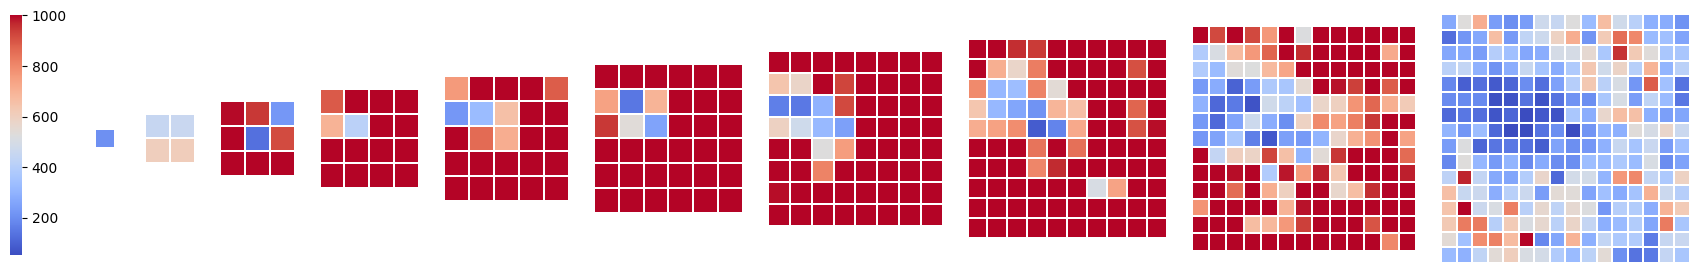

In [10]:
plot_heatmap(count_set_20, vmax=1000, vmin=50)

In [ ]:
recon_B3HW_50, map_mean_50, map_var_50, count_set_50, last_count_set_50, ratio_q_scores_50 = sample_images(var_50, vae_50, generate_maps=False, inpainting=False)

C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this oper

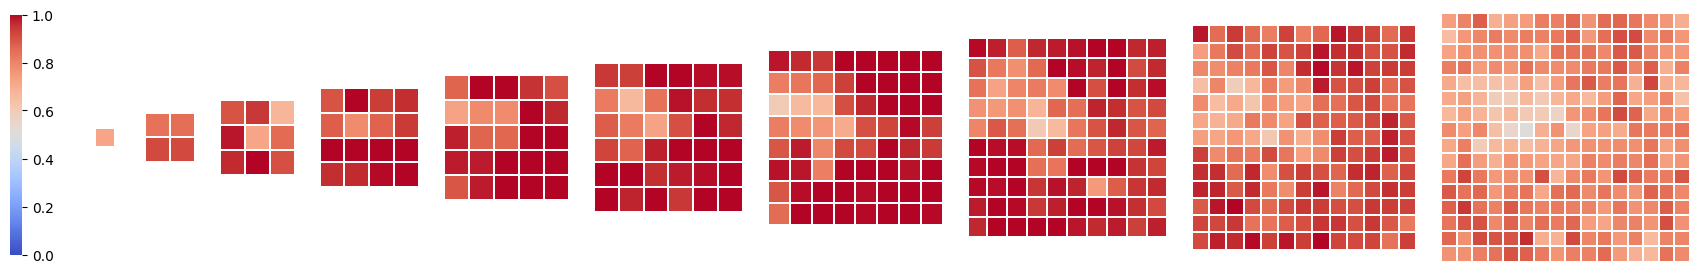

In [14]:
plot_heatmap(count_set_50[0], vmax=1, vmin=0)

C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)
C:\Users\laeti\AppData\Local\Temp\ipykernel_1868\4138880410.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this oper

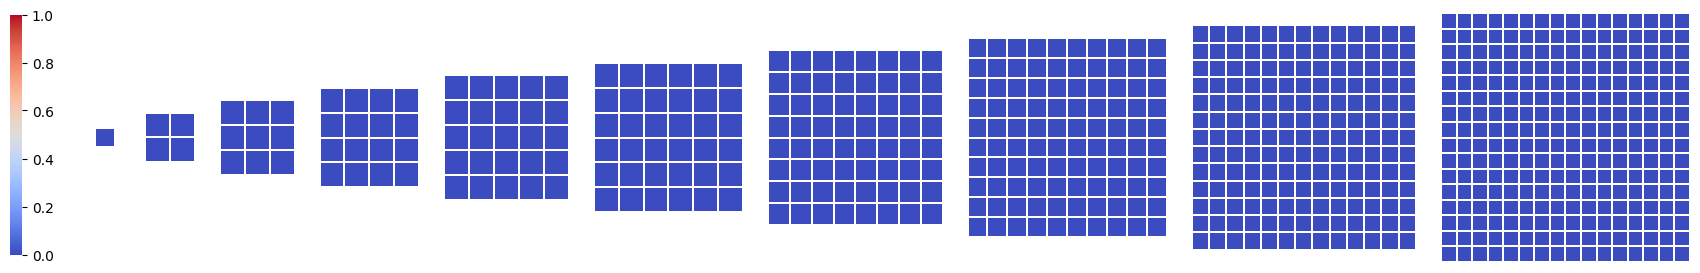

In [15]:
plot_heatmap(count_set_50[1], vmax=1, vmin=0)

In [ ]:
recon_B3HW_60, map_mean_60, map_var_60, count_set_60, last_count_set_60, ratio_q_scores_60 = sample_images(var_60, vae_60, generate_maps=False, inpainting=False)

In [ ]:
plot_heatmap(count_set_60[0], vmax=1, vmin=0)

In [ ]:
plot_heatmap(count_set_60[1], vmax=1, vmin=0)

In [ ]:
# image_pil = Image.open("ele_10.jpeg")
# image = np.array(image_pil, dtype=np.float32) / 255.0  # Normalize to [0,1]
# overlap_image_heatmap(map_var_70, image)
# image_pil = Image.open("tukan_gen.jpeg")
# image = np.array(image_pil, dtype=np.float32) / 255.0
# overlap_image_heatmap(map_var_70, image) #, title = "Association of Highest Uncert. Patches in Gen. Image")
# compare_generated_og("tukan_cropped.jpeg","tukan_gen.jpeg")

### Presentation Stuff

In [ ]:
plot_heatmap(count_set_20, vmax=count_set_20[3].max(), vmin=count_set_20[3].min(), title = "CPS with Cumulative Prob. Score - Set Sizes", title_y=0.7)

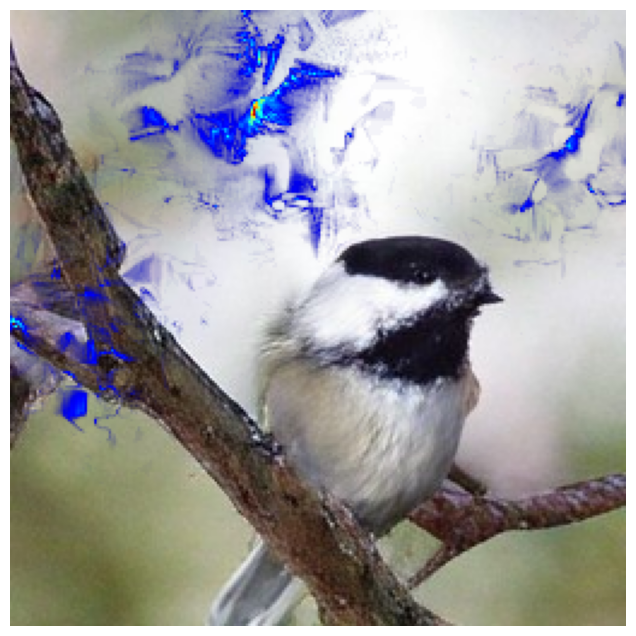

C:\Users\laeti\AppData\Local\Temp\ipykernel_13696\1090174840.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_13696\1090174840.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)


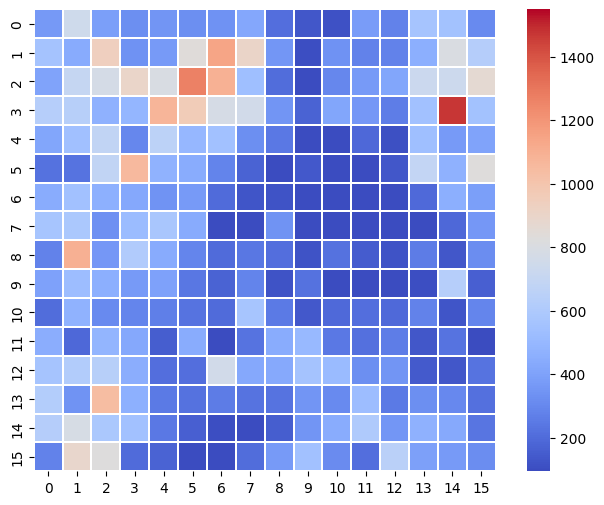

In [ ]:
# Overlap map and generated image
image20_pil = Image.open("vogel_gen.jpeg")
image20 = np.array(image20_pil, dtype=np.float32) / 255.0  # Normalize to [0,1]
overlap_image_heatmap(map_var_20, image20)
plot_heatmap(last_count_set_20, vmax=count_set_20[3].max(), vmin=count_set_20[3].min()) #, title="CPS Set Sizes Last Token Map", title_y = 1.0)

### Ansatz 50 vs 60

In [ ]:
vae_50, var_50 = load_prtnd_model(nmb="50", model_depth = 16)
vae_60, var_60 = load_prtnd_model(nmb="60", model_depth = 16)

In [ ]:
recon_B3HW_50, map_mean_50, map_var_50, count_set_50, last_count_set_50, ratio_q_scores_50 = sample_images(var_50, vae_50, generate_maps=True, inpainting=False)
plot_image(recon_B3HW_50)

In [ ]:
recon_B3HW_60, map_mean_60, map_var_60, count_set_60, last_count_set_60, ratio_q_scores_60 = sample_images(var_60, vae_60, generate_maps=True, inpainting=False)
plot_image(recon_B3HW_60)

C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)
C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

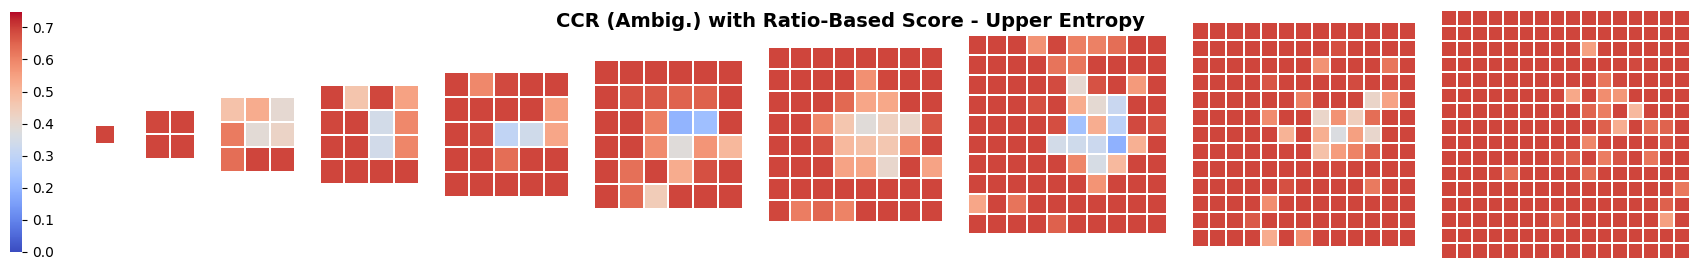

C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)
C:\Users\laeti\AppData\Local\Temp\ipykernel_16976\1090174840.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

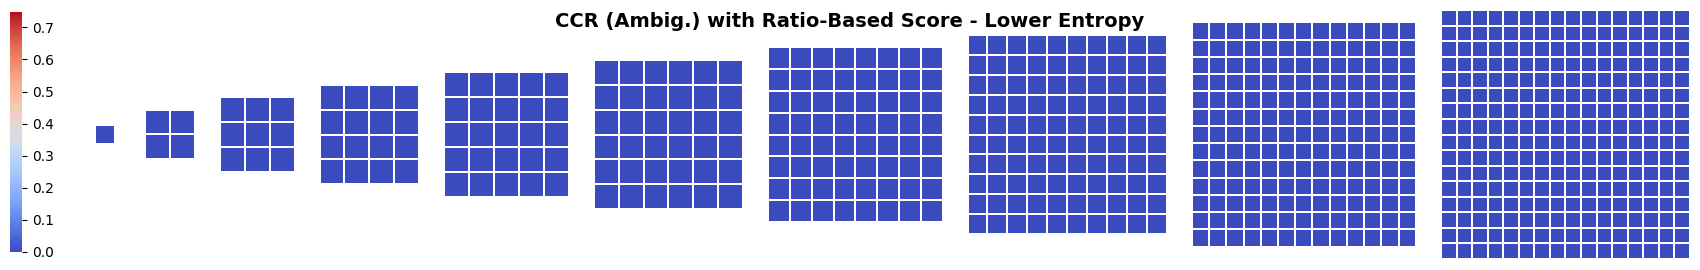

In [ ]:
plot_heatmap(count_set_60[0], vmax=0.75, vmin=0, title= "CCR (Ambig.) with Ratio-Based Score - Upper Entropy (TU)", title_y=0.7)
plot_heatmap(count_set_50[0], vmax=0.75, vmin=0, title= "CCR (Crisp) with Ratio-Based Score - Upper Entropy (TU)", title_y=0.7)
plot_heatmap(count_set_60[1], vmax=0.75, vmin=0, title= "CCR (Ambig.) with Ratio-Based Score - Lower Entropy (AE)", title_y=0.7)
plot_heatmap(count_set_50[1], vmax=0.75, vmin=0, title= "CCR (Crisp) with Ratio-Based Score - Lower Entropy (AE)", title_y=0.7)

In [ ]:
# Overlap map and generated image
image50_pil = Image.open("vogel_gen.jpeg")
image50 = np.array(image50_pil, dtype=np.float32) / 255.0  # Normalize to [0,1]
overlap_image_heatmap(map_var_60, image50)
plot_heatmap(last_count_set_60, vmax=1, vmin=0) #, title="CPS Set Sizes Last Token Map", title_y = 1.0)

## Inpainting

### General comparison - OG - vs inpainted

In [ ]:
vae_20, var_20 = load_prtnd_model(nmb="20", model_depth = 16)
vae_50, var_50 = load_prtnd_model(nmb="50", model_depth = 16)

In [ ]:
recon_B3HW_20, map_mean_20, map_var_20, count_set_20, last_count_set_20, ratio_q_scores_20 = sample_images(var_20, vae_20, generate_maps=True, inpainting=True)
plot_image(recon_B3HW_20)

In [ ]:
recon_B3HW_50, map_mean_50, map_var_50, count_set_50, last_count_set_50, ratio_q_scores_50 = sample_images(var_50, vae_50, generate_maps=True, inpainting=True)
plot_image(recon_B3HW_50)

C:\Users\laeti\AppData\Local\Temp\ipykernel_3148\3026144599.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_3148\3026144599.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)


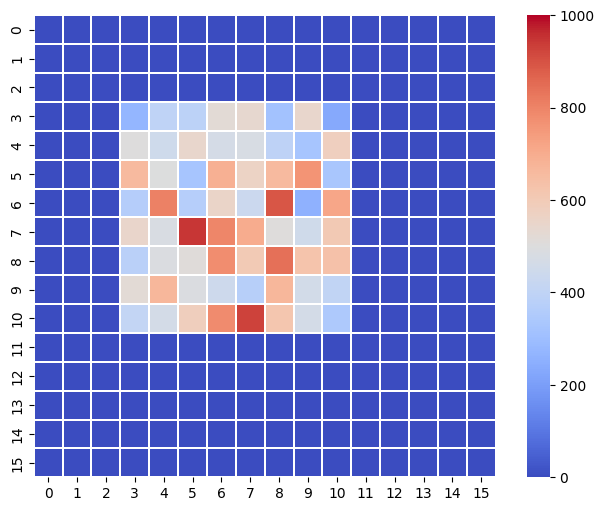

C:\Users\laeti\AppData\Local\Temp\ipykernel_3148\3026144599.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  size = int(np.sqrt(row.shape))
C:\Users\laeti\AppData\Local\Temp\ipykernel_3148\3026144599.py:101: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reshaped_row = np.array(row).reshape(size, size)


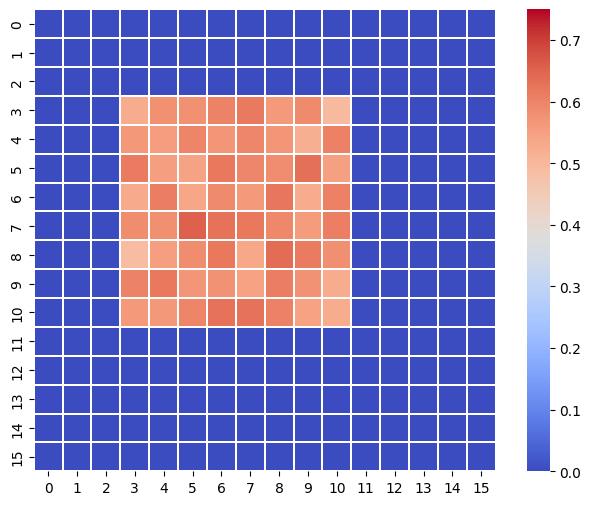

In [ ]:
plot_heatmap([last_count_set_20], vmin=0, vmax=1000) #, title = "CPS with Cuml. Prob. Score")
plot_heatmap([last_count_set_50], vmin=0, vmax=0.75) #, title = "CCR with Ratio-Based Score")

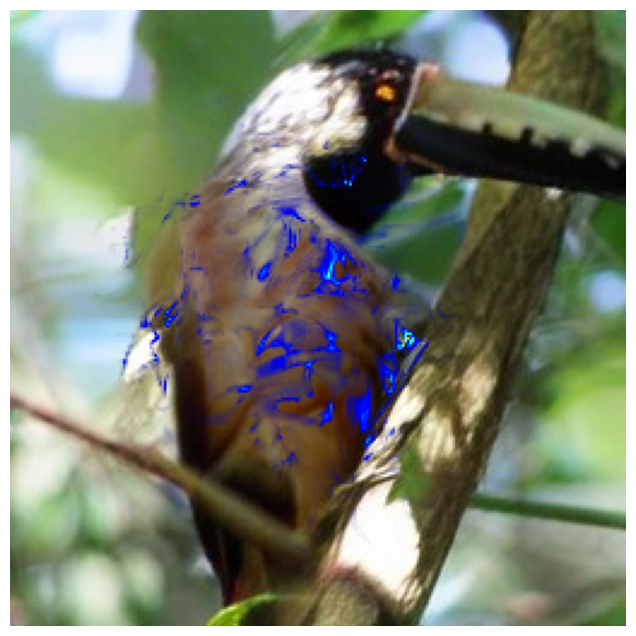

(256, 256)


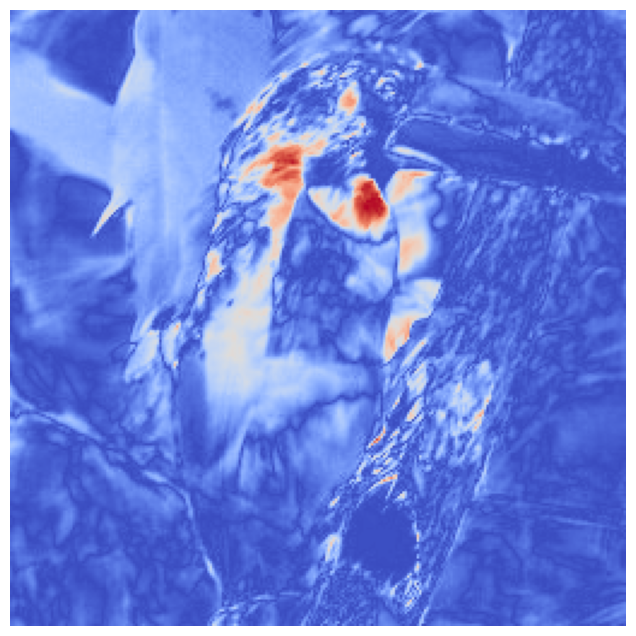

In [ ]:
image_pil = Image.open("tukan_gen.jpeg")
image = np.array(image_pil, dtype=np.float32) / 255.0
overlap_image_heatmap(map_var_20, image) #, title = "Association of Highest Uncert. Patches in Gen. Image")
compare_generated_og("tukan_cropped.jpeg","tukan_gen.jpeg")

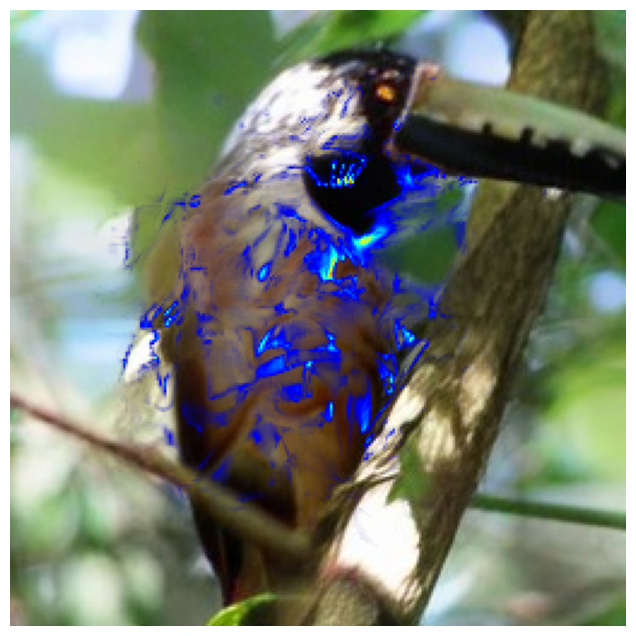

(256, 256)


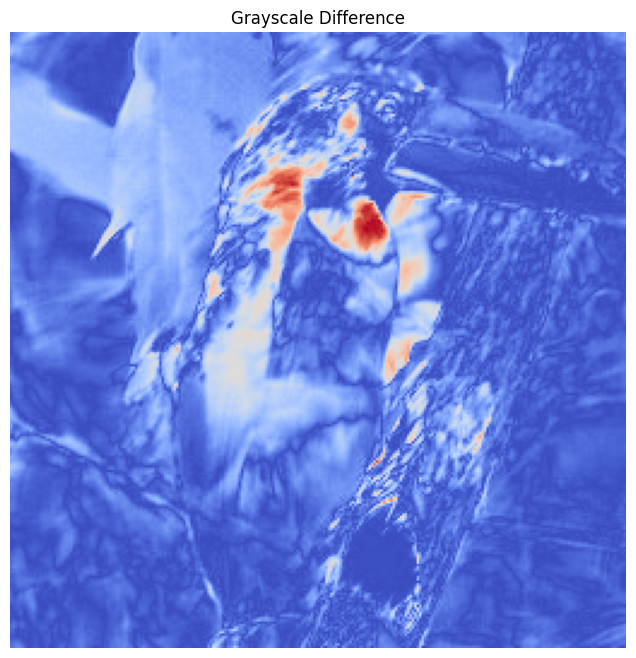

In [ ]:
image_pil = Image.open("tukan_gen.jpeg")
image = np.array(image_pil, dtype=np.float32) / 255.0
overlap_image_heatmap(map_var_50, image)
compare_generated_og("tukan_cropped.jpeg","tukan_gen.jpeg")